In [1]:
from cvxpy import *
# import gurobipy
import numpy as np
import scipy as sp
import pandas as pd
import cvxopt

In [2]:
# Function definition for constraints
def deferrableConstraints(p=np.asmatrix([1,2]).T,nT=24,earliestStart=1,latestStart=24):
# function constraintStruct = deferrableConstraints(p,nT,earliestStart,latestStart)
    # p: vector of power consumption in each time period; tall and skinny
    # nT: Number of time steps in the study period (i.e. 24h in a day)
    # earliestStart: Integer number of time step for allowable start
    # latestEnd: Integer number of time time step for latest start,

    # For Testing
#     p = def_profile
#     nT=24
#     earliestStart=8
    latestStart=nT-len(p)

    L = nT
    G = len(p) # Number of steps in operation of the deferrable load
    lbar = 1   # For MPC/CEC, this is the time step we're currently considering

    dim1 = L - lbar + 1
    dim2 = L - lbar + min(lbar, G)

    c1    = np.zeros((dim1,1))
    c1[0] = p[0]
    r1    = np.vstack((p,np.zeros((dim2-G,1))))
    omega = sp.linalg.toeplitz(c1,r1)

    r1   = np.zeros((dim2,1))
    r1[0]= 1
    r1[1]= -1
    c1   = np.zeros((dim2,1))
    c1[0]= r1[0]
    y = sp.linalg.toeplitz(c1,r1)

    # y.T * omega# * d  # This will produce the power consumption schedule for a given d 

    # Set up the a-vector (the dispatch command vector)
    maxDelay  = L - latestStart - earliestStart
    zeta = maxDelay    #zeta term from eqn (13b)

    a = np.vstack((np.zeros((earliestStart-1,1)),np.ones((L-earliestStart+1,1)))) # Not sure what these are doing
    a_shift = np.vstack((np.zeros((earliestStart+zeta,1)),np.ones((latestStart,1))))

    # Constraint matrix for d(l-1)<=d(l), or d(l-1)-d(l)<=0.
    #   Assumes that we prepend 0 to d for this constraint.
    A_increasing = sp.linalg.toeplitz(np.vstack((1,np.zeros((L-1,1)))),np.vstack((1,-1,np.zeros((L-1,1)))))
    # A_increasing = toeplitz([1;zeros(L-1,1)],[1;-1;zeros(L-1,1)]);

    constraintStruct = {}
    constraintStruct['y'] = y
    constraintStruct['omega'] = omega
    constraintStruct['A_increasing'] = A_increasing
    constraintStruct['a'] = a
    constraintStruct['a_shift'] = a_shift

    return constraintStruct

In [28]:
# Network Data

# Base values for Test Network
s_base = 1.0e3 #VA
v_base = 12.35e3 #V
z_base = (v_base**2)/s_base

# Test Network Data
basic_data = pd.read_csv('Data/basic_data.csv',header=None)#, columns=['f','t','r','x'])
basic_data.columns = ['f','t','r','x']

cutNode = len(basic_data); # include the whole network
cutNode = 17;  # Cut the network off after this node for faster run time. Good cuts: 17. Using Python indexing this is still 17, due to indexing!

# Convert into a model of the network
f = np.array(basic_data['f'].iloc[:cutNode])-1
t = np.array(basic_data['t'].iloc[:cutNode])-1
r = np.array(basic_data['r'].iloc[:cutNode])
x = np.array(basic_data['x'].iloc[:cutNode])
r = np.insert(r,0,0)/z_base
x = np.insert(x,0,0)/z_base
R = np.diag(r)
X = np.diag(x)
Rsub = R[1:,1:] # need these for constraints later
Xsub = X[1:,1:]

# Network Properties
nb = np.int64(max(t)+1)  # Number of buses
nl = np.int64(len(t))    # Number of lines

# parent = sparse(t,f,ones(nl,1),nb,nb); #column is the parent of row
# child = sparse(f,t,ones(nl,1),nb,nb); #column is the child of row (interestingly child = parent').

from scipy.sparse import coo_matrix

#column is the parent of row
parent = coo_matrix((np.ones((nl,)), (t, f)), shape=(nb,nb)).toarray() # Column is the parent of this row # Lose the to array if dealing with big matrices and use the Constant function for cvxpy.
child = coo_matrix((np.ones((nl,)), (f, t)), shape=(nb,nb)).toarray()  # Column is the child of this row (interestingly, child = parent')
parent = parent.astype(int)
child = child.astype(int)
# parent = Constant(parent)
# child = Constant(child)

# Time Data
T = np.int64(24) # if there is no time coupling, leave at 1 for low solve time.
dt = np.int64(1) # time step in hours

# Generator cost coefficients - random for now
# alpha = zeros(nb,1);
alpha = (0.1 + (0.2-0.1)*np.random.rand(nb,1))*s_base**2
beta = (10 + (20-10)*np.random.rand(nb,1))*s_base
gamma = 100 + (200-100)*np.random.rand(nb,1)

# Price of electricity from the grid (if we want grid-connected)
LMP_price = np.array(pd.read_csv('Data/EnergyPrice.csv',header=None))
price = LMP_price / max(LMP_price) # Scale to [0,1]

import numpy.random
g_min = np.zeros((nb,T)) # These are setup to give feeder lots of power, other buses less so.
g_max = (0.5e3 + (1e3-0.5e3)*np.random.rand(nl,1))
g_max = np.insert(g_max,0,nl*10e3)/s_base
import numpy.matlib
g_max = np.matlib.repmat(np.asmatrix(g_max).transpose(),1,T)

# Load Data - random for now
fixed_load_p = np.vstack((np.zeros((1,T)),(2e3 + (10e3-2e3)*np.random.rand(nl,T))))/s_base
fixed_load_q = np.vstack((np.zeros((1,T)),(100 + (200-1002)*np.random.rand(nl,T))))/s_base


# Scale loads using the price profile, with random noise 20% of the signal
fixed_load_p = 0.3 * fixed_load_p + 0.7 * np.dot(np.asmatrix(np.mean(fixed_load_p,axis=1)).T,price.transpose())
fixed_load_q = 0.3 * fixed_load_q + 0.7 * np.dot(np.asmatrix(np.mean(fixed_load_q,axis=1)).T,price.transpose())

nbOnes = np.ones((nb, 1)) # Use this to turn scalars into bus-vectors
ntOnes = np.ones((T,1))   # Use this to turn scalars into time-vectors
loadScale = 0.001;

# Solar data
p_sol = pd.read_csv('Data/SolarOutput.csv',header=None) # Just take solar output (not hours)
p_sol = p_sol[1] / max(p_sol[1]) # Normalize profile
p_sol = np.matlib.repmat(np.asmatrix(p_sol),nb,1) # Stack for each node
solar_probability = 0.6
solar_present = np.round(solar_probability - 0.5 + (np.random.rand(nb,1)))
max_sol = 1.5*np.multiply(np.max(fixed_load_p,axis=1),solar_present)# 1.5 is the factor by which the solar panel is designed to exceed demand;
p_sol = np.dot(np.diag(np.asarray(max_sol).flatten()),p_sol)  # Scale solar output by the max power of each node

# Deferrable Load 
def_profile = np.asmatrix([0.1, 1.5, 2.0, 0.5, 0.5, 1.0]).T # Demand profile for the deferrable load
# def_profile= np.asmatrix([1,2]).T  # Simple test load
def_profile = def_profile / max(def_profile)
def_profile = def_profile*np.mean(np.max(fixed_load_p,axis=1))  # Scale so that the fixed load maximum is the same as the average household maximum
steps = len(def_profile)
defConst = deferrableConstraints(def_profile, T, 8) # Generate constraints in form (p, T, ,earliestStart,latestStart)

# Battery parameters
eff_in = 0.95 # Battery efficiency
eff_out = 0.95  
p_battmax = np.max(fixed_load_p,axis=1)*0.5;
hours = 4
battsize = hours * p_battmax          # Battery size in Watts*dt (i.e. Wh if dt=1 hour)
E_min = 0.2 * battsize  # SOC lower limits on batteries
E_max = 0.8 * battsize  # SOC lower limits on batteries
# E_init = 0.5 * battsize # Starting state of charge
eps = 0.001              # Acceptable band for ending SOC 

# Shapeable load parameters
P_shpmin = 0 * np.max(fixed_load_p,axis=1)
P_shpmax = 2 * np.max(fixed_load_p,axis=1)
E_dem = 3 * np.multiply(np.random.rand(nb,1),P_shpmax)    # Effectively how many hours of demand we have
minStartTime = 9
minStartTime = min(T-4,minStartTime) # Deal with short time horizons
startProbPeriod = 9 # Start times will be uniformly distributed over this range
startAfter = minStartTime + np.round(startProbPeriod * np.random.rand(nb,1).flatten())
chargeTime = 4 + np.round(min(6,T-4) * np.random.rand(nb,1).flatten())
endBy = np.minimum(startAfter + chargeTime,T)

# Create a matrix where infeasible hours are 0 - buses in rows, times in columns
selectShp = np.zeros((nb,T))
for i in range(nb):# = 1:nb:
    tooEarly = np.ones(  ( 1,int(startAfter[i]) ) )
    okTimes  = np.zeros( ( 1,int(endBy[i]-startAfter[i]) ) )
    tooLate  = np.ones(  ( 1,int(T-endBy[i]) ) )
    selectShp[i,:] = np.hstack(( tooEarly, okTimes, tooLate))


In [40]:
### Simple OPF Problem  ###
# Dispatchable generators, linear generation costs, 
# Fixed loads, no deferrable or shapeable loads

nb = int(nb)
T = int(T)

# Line flow variables
P = Variable(nb,T)  # Real power flow from node to parent
Q = Variable(nb,T)  # Reactive power flow from node to parent
# l = Variable(nb,T)
v = Variable(nb,T)  # squared voltage at node

# Dummy variables
p_g = Variable(nb,T)  # Generation real power
q_g = Variable(nb,T)  # Generation reactive power
p = Variable(nb,T)    # Nodal net power injection
q = Variable(nb,T)
# temp_var = Variable(3,T)

alpha = np.random.rand(nb,1)
beta = 20*np.random.rand(nb,1)
obj = 0
for t in range(T):
#     obj = obj + beta.T*p_g[:,t]
    obj = obj+alpha.T*(square(p_g[:,t]))+beta.T*p_g[:,t]
    
objective = Minimize(obj)
constraints = []

# Linearized Power Flow Equations
constraints.append(p == P - child*P) # Lambda (prices) associated with this equation
constraints.append(q == Q - child*Q)
constraints.append(v[1:,:] == parent[1:,:]*v+2*(Rsub*P[1:,:]+Xsub*Q[1:,:]))

# Injection Equations - Simple
constraints.append(p == p_g - fixed_load_p)
constraints.append(q == q_g - fixed_load_q)

# Voltage constraints
constraints.append(v <= 1.05)
constraints.append(v >= 0.95)
# Generator constraints
constraints.append(g_min <= p_g)
constraints.append(p_g <= g_max)

# Root node constraints (root voltage is slack)
constraints.append(P[0,:] == 0)
constraints.append(Q[0,:] == 0)

prob = Problem(objective, constraints)
prob.solve(solver=ECOS)

# Solve it!
result = prob.solve()
print("Objective value: %.3f"%prob.value)
# print("Value of p: %s"%np.round(p.value,3).T.tolist()[0]) 

# Pull out values like
# P.value[1,:]  # Power flow from bus 1 to parent over every hour


Objective value: 30014.079


In [38]:
### FULL SMARTGRID PROBLEM ####
# Deferable and shapeable loads

# Set up constants
# a = np.array([1,1]).T
# b = 3
# c = np.array([-2,1]).T
# rho = np.array([0.5,0.5]);

# n = max(a.shape)

# Set up CVXPy problem

nb = int(nb)
T = int(T)

# Opt variables
P = Variable(nb,T)
Q = Variable(nb,T)
l = Variable(nb,T)
v = Variable(nb,T)

# Dummy variables
p_g = Variable(nb,T)
q_g = Variable(nb,T)
p = Variable(nb,T)
q = Variable(nb,T)

# Deferrable decision variable
# d = Variable(nb,T) # nonnegative
# Battery variables
p_bc = Variable(nb,T)
p_bd = Variable(nb,T)
E_batt = Variable(nb,T)
# Shapeable load variables
p_shp = Variable(nb,T) #nonnegative

# p_def = np.zeros((nb,T))
# for i in range(nb):
#     p_def[i,:] = (np.dot(defConst['y'].T,defConst['omega'].T)*d[i,:].T).T # Deferrable  load calculation

# p_def = d*(np.dot(defConst['y'].T,defConst['omega'].T))
p_batt = p_bd-p_bc # batteries

alpha = np.random.rand(nb,1)
beta = np.vstack((LMP_price.T,20*np.random.rand(nb-1,T)))
obj = 0
for t in range(T):
#     obj = obj + beta.T*p_g[:,t]
    obj = obj+alpha.T*(square(p_g[:,t]))+beta[:,t].T*p_g[:,t]
    
objective = Minimize(obj)
constraints = []

# # Power Flow Equations
# constraints.append(p == P - child*P + R*l) # Lambda (prices) associated with this equation
# constraints.append(q == Q - child*Q + X*l)
# constraints.append(v[1:,:] == parent.astype(int)[1:,:]*v+2*(Rsub*P[1:,:]+Xsub*Q[1:,:])-(Rsub*Rsub+Xsub*Xsub)*l[1:,:])

# Linearized Power Flow Equations
constraints.append(p == P - child*P) # Lambda (prices) associated with this equation
constraints.append(q == Q - child*Q)
constraints.append(v[1:,:] == parent[1:,:]*v+2*(Rsub*P[1:,:]+Xsub*Q[1:,:]))

# for t in np.arange(T):
#     for i in np.arange(1,nb):
# #         constraints.append(l[i,t]+v[i,t] >= norm(np.vstack((2*P[i,t],2*Q[i,t],l[i,t]-v[i,t])),2))
#         temp_square = square(2*P[i,t])+square(2*Q[i,t])+square(l[i,t]-v[i,t])
#         constraints.append(l[i,t]+v[i,t] >= sqrt(temp_square))#norm([[2*P[i,t]],[2*Q[i,t]],[l[i,t]-v[i,t]]],2))
#         [[2*P[i,t]],[2*Q[i,t]],[l[i,t]-v[i,t]]]
        #l(i,t) >= (P(i,t)^2+Q(i,t)^2)/v(i,t);
#         [2*P[i,t];2*Q[i,t];l[i,t]-v[i,t]]

# Injection Equations
# constraints.append(p == p_g + p_sol + p_batt - p_def - p_shp - fixed_load_p)  # Uncomment this to include solar
constraints.append(p == p_g + p_sol + p_batt - p_shp - fixed_load_p)  # Uncomment this to include solar

# p == p_g + p_batt - p_def - p_shp - fixed_load_p; % This assumes no solar
constraints.append(q == q_g - fixed_load_q)

# # Injection Equations - Simple
# constraints.append(p == p_g - fixed_load_p)
# constraints.append(q == q_g - fixed_load_q)

# Voltage cons
constraints.append(v <= 1.05)
constraints.append(v >= 0.95)
# Gen cons
constraints.append(g_min <= p_g)
constraints.append(p_g <= g_max)
# Root node cons (root voltage is slack)
constraints.append(P[0,:] == 0)
constraints.append(Q[0,:] == 0)

# # Deferrable loads
# for i in range(nb):
#     constraints.append(defConst['A_increasing'] * np.insert(d[i,:].T,0,0) <= 0)  # d(l-1) <= d(l), eqn (13a)
#     constraints.append(d[i,:].T <= defConst['a'])                     # d(l) <= a(l)  , eqn (13a)
#     constraints.append(defConst['a_shift'] <= d[i,:].T)               # a(l-zeta) <= d(l), eqn (13b)
#     constraints.append(d[i,0]==0)                    # d(0) == 0
#     constraints.append(d[i,T]== defConst['a'][T])             # d(L) == a(L)    eqn (13c)
    
#     # Nonnegative constraints
#     constraints.append(d >= 0)
    
# Batteries
constraints.append(0 <= p_bd)
constraints.append(p_bd<= p_battmax * ntOnes.T)
constraints.append(0 <= p_bc)
constraints.append(p_bc<= p_battmax * ntOnes.T)
constraints.append(E_min * ntOnes.T <= E_batt)
constraints.append(E_batt <= E_max * ntOnes.T)

constraints.append(E_batt[:,0] == E_batt[:,T-1] + p_bc[:,0] * dt * eff_in - p_bd[:,0]*dt/eff_out)
for t in np.arange(1,T):
    constraints.append(E_batt[:,t] == E_batt[:,t-1] + p_bc[:,t] * dt * eff_in - p_bd[:,t]*dt/eff_out)
    
#         constraints.append(E_batt[:,1] == E_init)
constraints.append((1-eps)*E_batt[:,0] <= E_batt[:,T-1])# <= (1+eps)*E_batt[:,0])
constraints.append(E_batt[:,T-1] <= (1+eps)*E_batt[:,0])

# Shapeable loads
constraints.append(P_shpmin * ntOnes.T <= p_shp)
constraints.append(p_shp <= P_shpmax * ntOnes.T)
for i in np.arange(nb):
    constraints.append(ntOnes.T * p_shp[i,:].T == E_dem[i])      # Total energy consumption
    constraints.append(selectShp[i,:] * p_shp[i,:].T == 0)  # No operation during non-allowed hours

# Nonnegative constraints
constraints.append(p_shp >= 0)

prob = Problem(objective, constraints)
prob.solve(solver=ECOS)

# Solve it!
result = prob.solve()
print("Objective value: %.3f"%prob.value)

Objective value: 104215.059


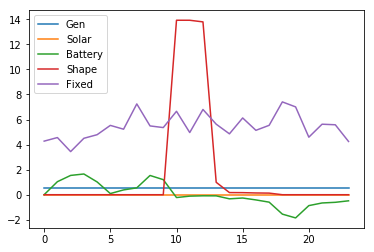

In [139]:
# p_g + p_sol + p_batt - p_shp - fixed_load_p
# p_g
# E_batt.value.astype(int)
# p.value.astype(int)

import matplotlib.pyplot as plt
%matplotlib inline 

node = 3
plt.plot(np.arange(T),p_g[node,:].value.T,label='Gen')
plt.plot(np.arange(T),-p_sol[node,:].T,label='Solar')
plt.plot(np.arange(T),-p_batt[node,:].value.T,label='Battery')
plt.plot(np.arange(T),p_shp[node,:].value.T,label='Shape')
plt.plot(np.arange(T),fixed_load_p[node,:].T,label='Fixed')
# plt.legend([a,b,c,d,e], ['Gen', 'Solar','Battery','Shape','Fixed'])
plt.legend(loc=2)
# ax.set_xticklabels(end.strftime('%m-%Y'),size = 'small')
# plt.xticks(end.strftime('%m%Y'))#,size='small')
# plt.xlabel('Date')
# plt.ylabel('Number of Members')
plt.show()